## ***Part A:Airbnb Price Prediction and Insights***

Initial Shape: (74111, 29)

Missing Values:
 id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     968
bedrooms                     91
beds                        131
dtype: int64

Data Types:
 

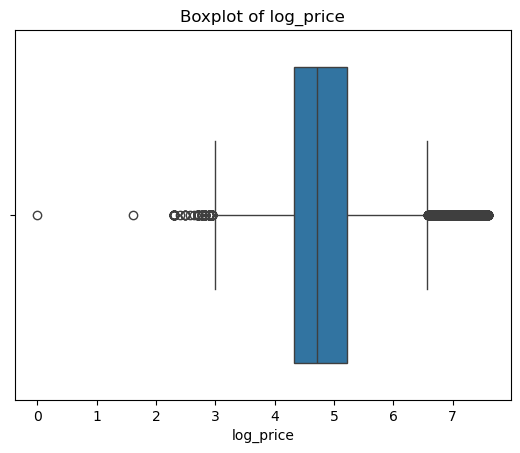

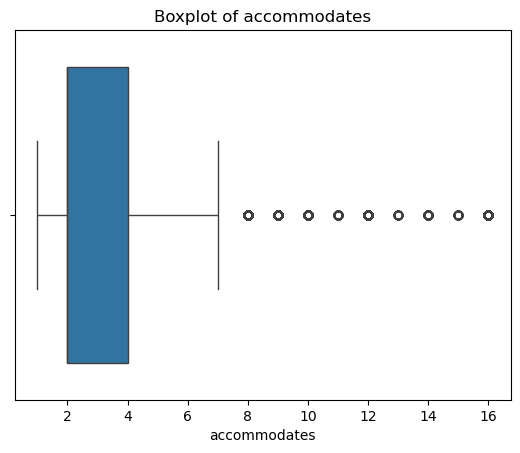

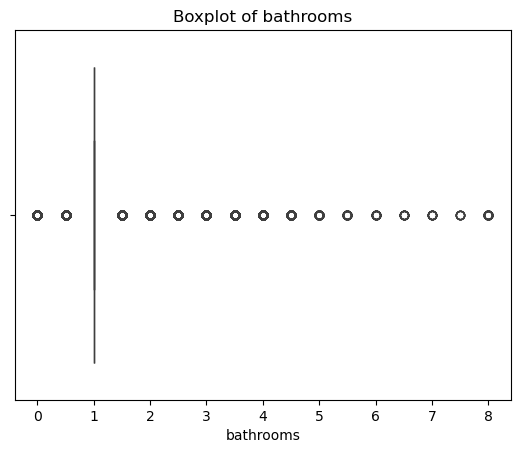

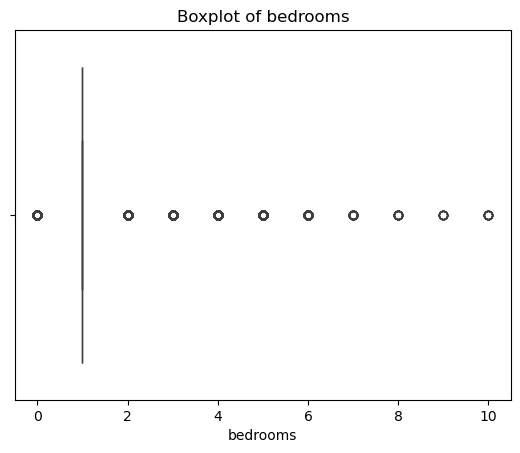

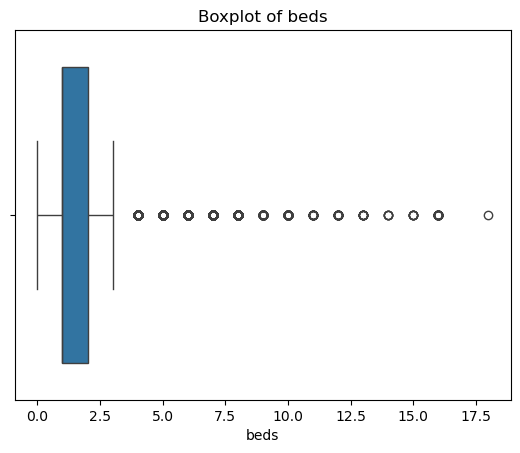

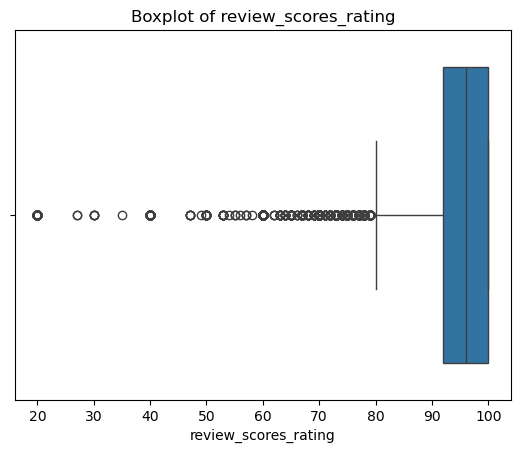

C:\Users\kshiv\AppData\Local\Temp\ipykernel_9608\2985064590.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
C:\Users\kshiv\AppData\Local\Temp\ipykernel_9608\2985064590.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 


Model Evaluation Results:
               Model    RMSE     MAE  R² Score
0  Linear Regression  0.4812  0.3637    0.5492
1   Ridge Regression  0.4812  0.3637    0.5492
2      Random Forest  0.3898  0.2800    0.7043
3  Gradient Boosting  0.4128  0.3013    0.6684


In [9]:
# Import necessaries Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# -----------------------------------------------------------
# 1. DATA EXPLORATION AND PREPROCESSING
# -----------------------------------------------------------

# Load dataset
df = pd.read_csv("Airbnb_data.csv")
print("Initial Shape:", df.shape)

# Basic EDA
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
print("\nBasic Statistics:\n", df.describe())

# Visualize numerical outliers
num_cols = ['log_price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating']
for col in num_cols:
    if col in df.columns:
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

# Handle missing values
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['beds'].fillna(df['beds'].median(), inplace=True)
df['review_scores_rating'].fillna(df['review_scores_rating'].median(), inplace=True)
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)
df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace=True)

# Map booleans
bool_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    df[col] = df[col].map({'t': 1, 'f': 0})

# Handle date columns
for date_col in ['host_since', 'first_review', 'last_review']:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df[date_col].fillna(df[date_col].min(), inplace=True)

# Feature engineering
df['description_length'] = df['description'].fillna('').apply(len)
df['num_amenities'] = df['amenities'].fillna('').apply(lambda x: len(x.split(',')))
df['host_duration'] = (datetime.now() - df['host_since']).dt.days
df['days_since_last_review'] = (datetime.now() - df['last_review']).dt.days

# Encode categorical features
label_cols = ['room_type', 'bed_type', 'cancellation_policy', 'property_type', 'city']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Drop unused or text-heavy columns
drop_cols = ['id', 'name', 'description', 'amenities', 'thumbnail_url', 'zipcode',
             'host_since', 'first_review', 'last_review', 'neighbourhood']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Final check before modeling
df = df.dropna(subset=['log_price'])  # Drop rows where target is missing
X = df.drop(columns=['log_price'])
y = df['log_price']

# Select only numeric features and fill remaining NaNs
X = X.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------------------------
# 2. MODEL DEVELOPMENT
# -----------------------------------------------------------

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    predictions[name] = preds

# -----------------------------------------------------------
# 3. MODEL EVALUATION
# -----------------------------------------------------------

results = []
for name, preds in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({
        'Model': name,
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R² Score': round(r2, 4)
    })

results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print(results_df)

# Optional: Save clean data and results
df.to_csv("Airbnb_cleaned.csv", index=False)
results_df.to_csv("Airbnb_model_results.csv", index=False)
